In [5]:
import torch
import utils.data_utils
import numpy as np
import librosa
import librosa.display 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# figure(figsize=(20, 10), dpi=80)
plt.rcParams['figure.figsize'] = [15, 15]
import model
import soundfile
import umap
import random

In [6]:
def load_model(ckpt):
    bwg = model.BiWaveGAN(
        slice_len=32768,
        latent_dim=ckpt['latent dim'], 
        model_size=ckpt['model size'], 
        discrim_filters=ckpt['disrim filters'],
        z_discrim_depth=ckpt['z discrim depth'],
        joint_discrim_depth=ckpt['joint discrim depth'],
        phaseshuffle_rad=ckpt['phaseshuffle rad'],
        device=device)
    bwg.G.load_state_dict(ckpt['G state_dict'])#, strict=strict)
    bwg.E.load_state_dict(ckpt['E state_dict'])
    bwg.D.load_state_dict(ckpt['D state_dict'])
    bwg.eval()
    
    return bwg 

def spectrogram(x, n_fft=512, hop_length=128, win_length=None):
    """
    Creates a spectrogram from a loaded audio file
    """
    S = np.abs(librosa.stft(x, n_fft, hop_length, win_length)) ** 2
    S = librosa.power_to_db(S)
    return S


In [7]:
device = 'cpu'
ckpt_path = "model_150k.ckpt"
ckpt = torch.load(ckpt_path, map_location=torch.device(device))
biwavegan = load_model(ckpt)
print(ckpt.keys())
print(ckpt['iter'])

dict_keys(['slice len', 'latent dim', 'model size', 'phaseshuffle rad', 'disrim filters', 'z discrim depth', 'joint discrim depth', 'G state_dict', 'E state_dict', 'D state_dict', 'EG optimiser', 'D optimiser', 'iter', 'EG losses', 'D losses', 'val recon errors'])
150000


In [10]:
ckpt['latent dim']

10

In [8]:
real_data_path = 'train'
real_dataset = utils.data_utils.WAVDataset(real_data_path, 250000, 32768)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=16)
print(len(real_dataset))

28329


Sample of Real Data

In [5]:
random.sample(range(len(real_dataset)), 16)

[20783,
 6193,
 960,
 15795,
 27120,
 8142,
 9580,
 12053,
 20208,
 15468,
 23069,
 14966,
 23599,
 12508,
 4157,
 24723]

In [6]:
sample_idx = random.sample(range(len(real_dataset)), 16)
real_x = []
for i in sample_idx:
    real_x.append(np.array(real_dataset[i]))

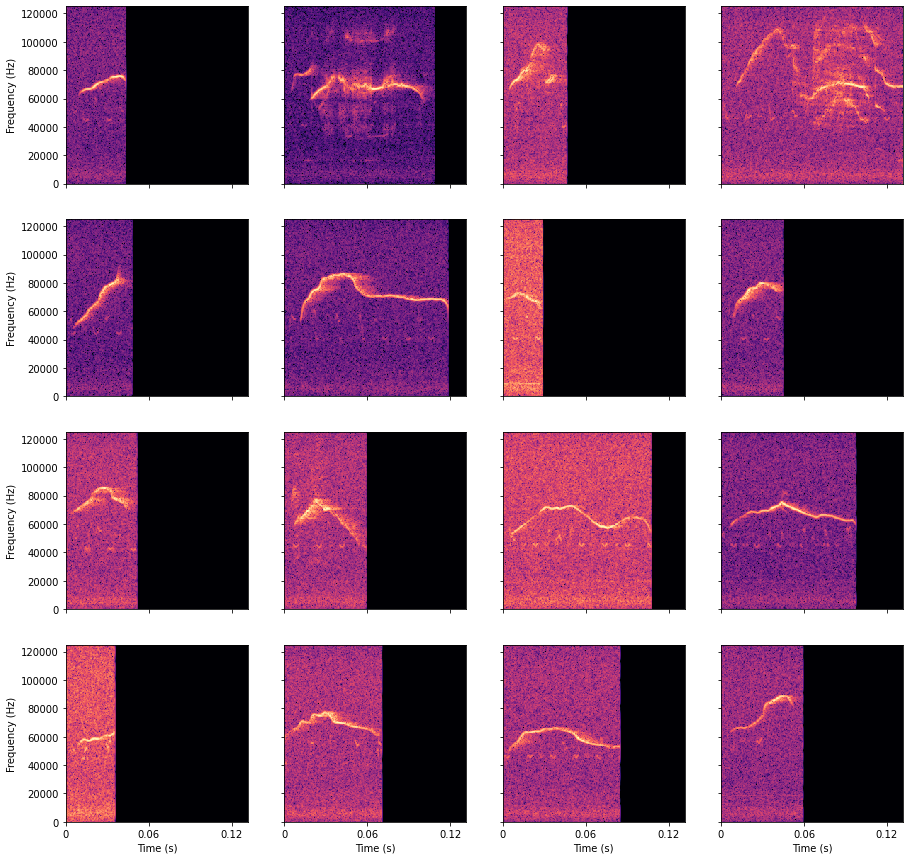

In [7]:
f, axarr = plt.subplots(4, 4, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        x_ij = real_x[i*4+j].flatten()
        D = librosa.stft(x_ij, n_fft=512, hop_length=128)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        librosa.display.specshow(S_db, sr=250000, hop_length=128, ax=axarr[i,j], x_axis='time', y_axis='linear')
        xlabel = "Time (s)" if i == 3 else ""
        ylabel = "Frequency (Hz)" if j == 0 else ""
        axarr[i,j].set(xlabel=xlabel, ylabel=ylabel, xticks=[0,0.06,0.12])
plt.show()
f.savefig('f.png')

In [8]:
# f.savefig('realdata.png')

Sample of generated data

In [11]:
# Uniform random sampling
# torch.manual_seed(1)
z = torch.Tensor(16, biwavegan.latent_dim).uniform_(-1, 1).to(device)
x = biwavegan.generate(z)
#x_recon = biwavegan.reconstruct(x).detach().numpy()
x = x.detach().numpy()

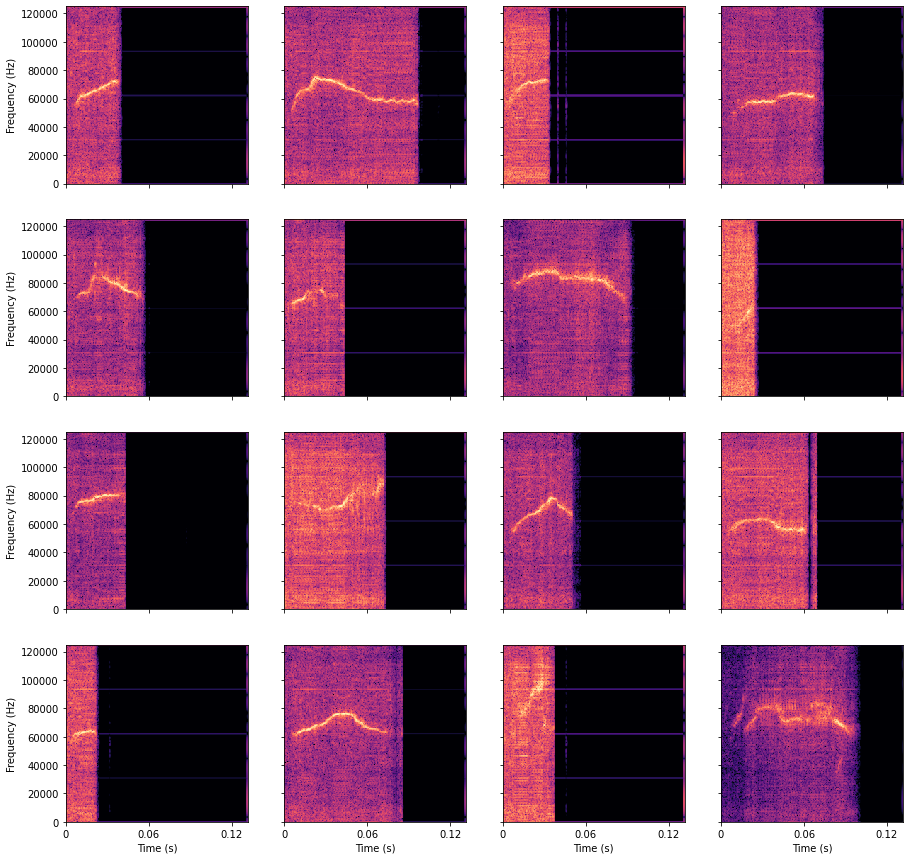

In [57]:
f, axarr = plt.subplots(4, 4, sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        x_ij = x[i*4+j].flatten()
        D = librosa.stft(x_ij, n_fft=512, hop_length=128)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        librosa.display.specshow(S_db, sr=250000, hop_length=128, ax=axarr[i,j], x_axis='time', y_axis='linear')
        xlabel = "Time (s)" if i == 3 else ""
        ylabel = "Frequency (Hz)" if j == 0 else ""
        axarr[i,j].set(xlabel=xlabel, ylabel=ylabel, xticks=[0,0.06,0.12])
plt.show()


In [13]:
# f.savefig('fakedata.png')

Reconstruction

In [2]:
real_dataset[i]

NameError: name 'real_dataset' is not defined

In [86]:
num_recons = 20
sample_idx = random.sample(range(len(real_dataset)), num_recons)
init_x = []
recon_x = []
for i in sample_idx:
    init_x.append(real_dataset[i].numpy().squeeze())
    recon_x.append(biwavegan.reconstruct(real_dataset[i].unsqueeze(0)).detach().numpy().squeeze())
init_recon_x = []
for i in range(num_recons):
    init_recon_x.append(init_x[i])
    init_recon_x.append(recon_x[i])

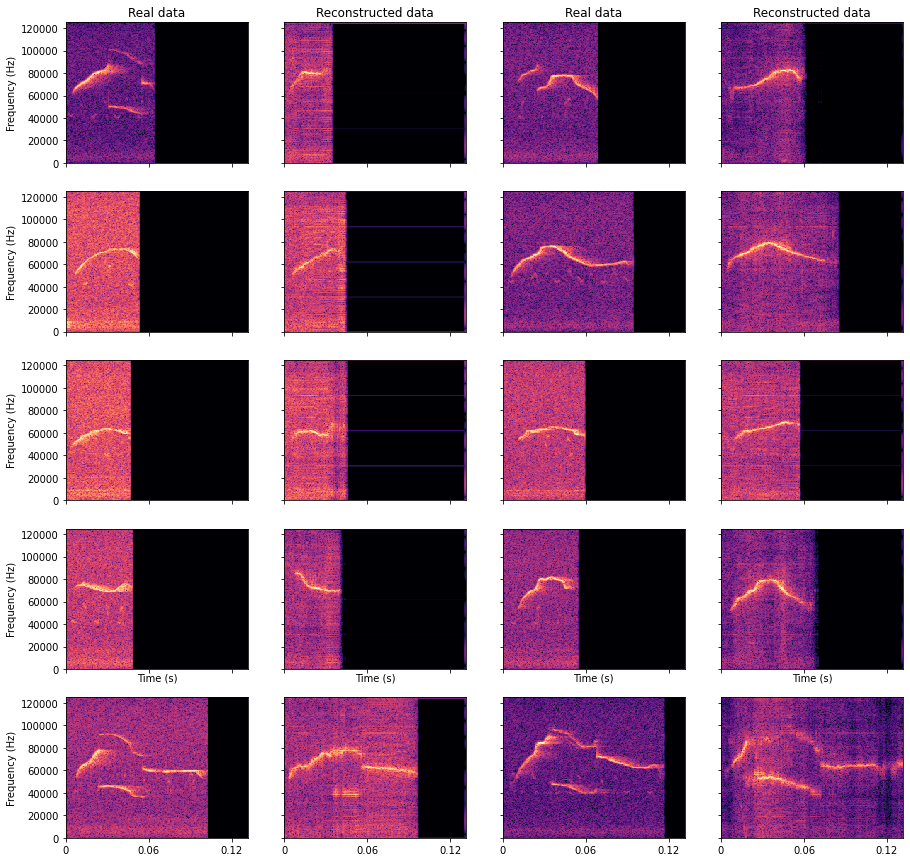

In [87]:
num_rows = 4
num_columns = num_recons // num_rows

f, axarr = plt.subplots(num_columns, num_rows, sharex=True, sharey=True)
for i in range(num_columns):
    for j in range(num_rows):
        x_ij = init_recon_x[i*num_rows+j].flatten()
        D = librosa.stft(x_ij, n_fft=512, hop_length=128)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        librosa.display.specshow(S_db, sr=250000, hop_length=128, ax=axarr[i,j], x_axis='time', y_axis='linear')
        xlabel = "Time (s)" if i == 3 else ""
        ylabel = "Frequency (Hz)" if j == 0 else ""
        if i == 0:
            title = "Real data" if j % 2 == 0 else "Reconstructed data"
        else:
            title = None
        
        axarr[i,j].set(xlabel=xlabel, ylabel=ylabel, xticks=[0,0.06,0.12], title=title)
plt.show()
# f.savefig('f.png')

In [88]:
# f.savefig('Reconstructions.png')

Interpolation

In [89]:
num_intrs = 8
intr_len = 10

z0 = torch.Tensor(num_intrs, biwavegan.latent_dim).uniform_(-1, 1).to(device)
z1 = torch.Tensor(num_intrs, biwavegan.latent_dim).uniform_(-1, 1).to(device)

intr_list = []
for i in range(num_intrs):
    intr = []
    for j in range(intr_len):
        z_j = (1 - j / intr_len) * z0[i] + (j / intr_len) * z1[i]
        x_j = biwavegan.generate(z_j).detach().numpy().squeeze()
        intr.append(x_j)
    intr_list.append(intr)

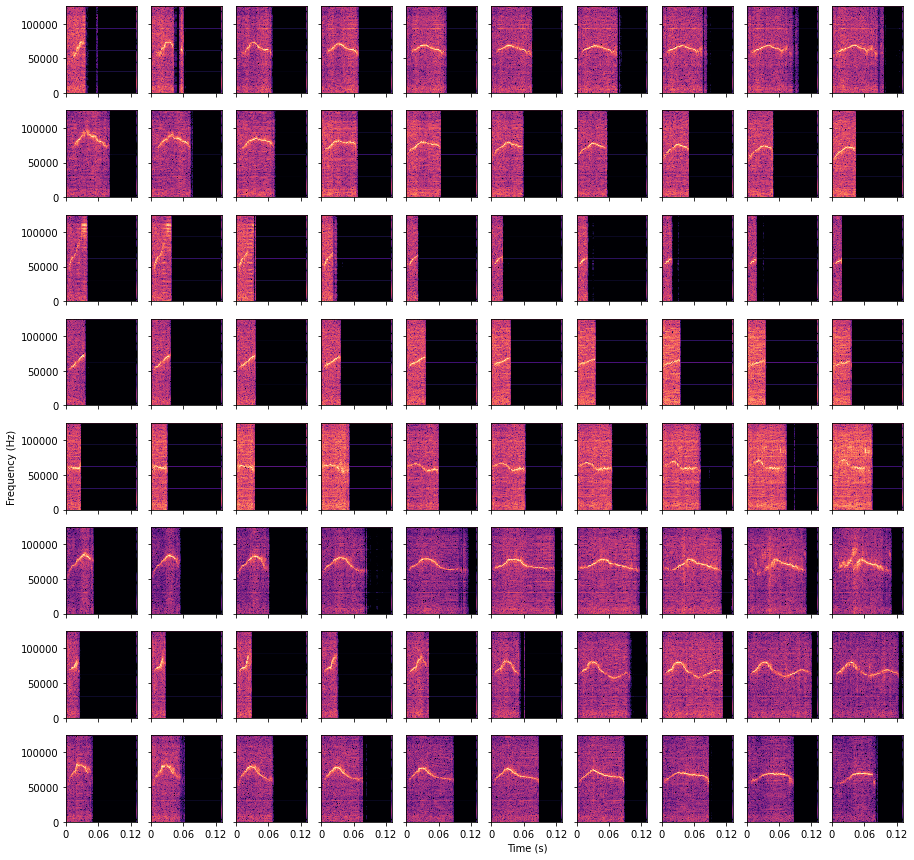

In [90]:
f, axarr = plt.subplots(num_intrs, intr_len, sharex=True, sharey=True)

for i in range(num_intrs):
    for j in range(intr_len):
        x_ij = intr_list[i][j]
        D = librosa.stft(x_ij, n_fft=512, hop_length=128)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        librosa.display.specshow(S_db, sr=250000, hop_length=128, ax=axarr[i,j], x_axis='time', y_axis='linear')
        xlabel = "Time (s)" if i == num_intrs - 1 and j == intr_len // 2 else ""
        ylabel = "Frequency (Hz)" if j == 0 and i == num_intrs // 2 else ""
        axarr[i,j].set(xlabel=xlabel, ylabel=ylabel, xticks=[0,0.06,0.12])
plt.show()
# f.savefig('intr.png')

In [91]:
f.savefig('Interpolations.png')